In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import data_utils, evaluation_utils
from src.data.some_dataloader import get_dataset, get_dataset2
from src.scripts import rdkit_extraction
from src.utils import evaluation_utils
from sklearn.cluster import KMeans,SpectralClustering
from scikit_posthocs import posthoc_dunn
import os
import zipfile
from sklearn.model_selection import train_test_split

#Imports to get rid of warnings
import warnings
from rdkit import RDLogger
import plotly.express as px
import scipy.stats as stats
RDLogger.DisableLog('rdApp.warning')
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

#Set a palette for all plots
sns.set_palette('Paired')

### Train-Test Split Validation

To validate our results, we conductethe most relevantar analysis to the one in `results.ipynb`, but with the dataset divided into 80% for training and 20% for testing. This approach was used to evaluate potential imbalances in the datas and to be sure our findings were valid. We are going to do a parallel analysis were the hypotesis testing are made with this separation of the datt.


In [6]:
df_std = get_dataset()
hiv = df_std[df_std['Target Source Organism According to Curator or DataSource'] == 'Human immunodeficiency virus 1']
hiv = data_utils.select_metric(hiv, 'IC50 (nM)')
hiv = data_utils.clean_na_columns(hiv)
hiv_condensed = evaluation_utils.group_similar_targets(hiv)


## Target analysis (dataset splitted)

In [78]:

train_df, test_df = train_test_split(hiv_condensed, test_size=0.2, random_state=40)


Here we verify our findings about Gag-pol protein being the one with the lowest median od IC50 with the splitted data set:

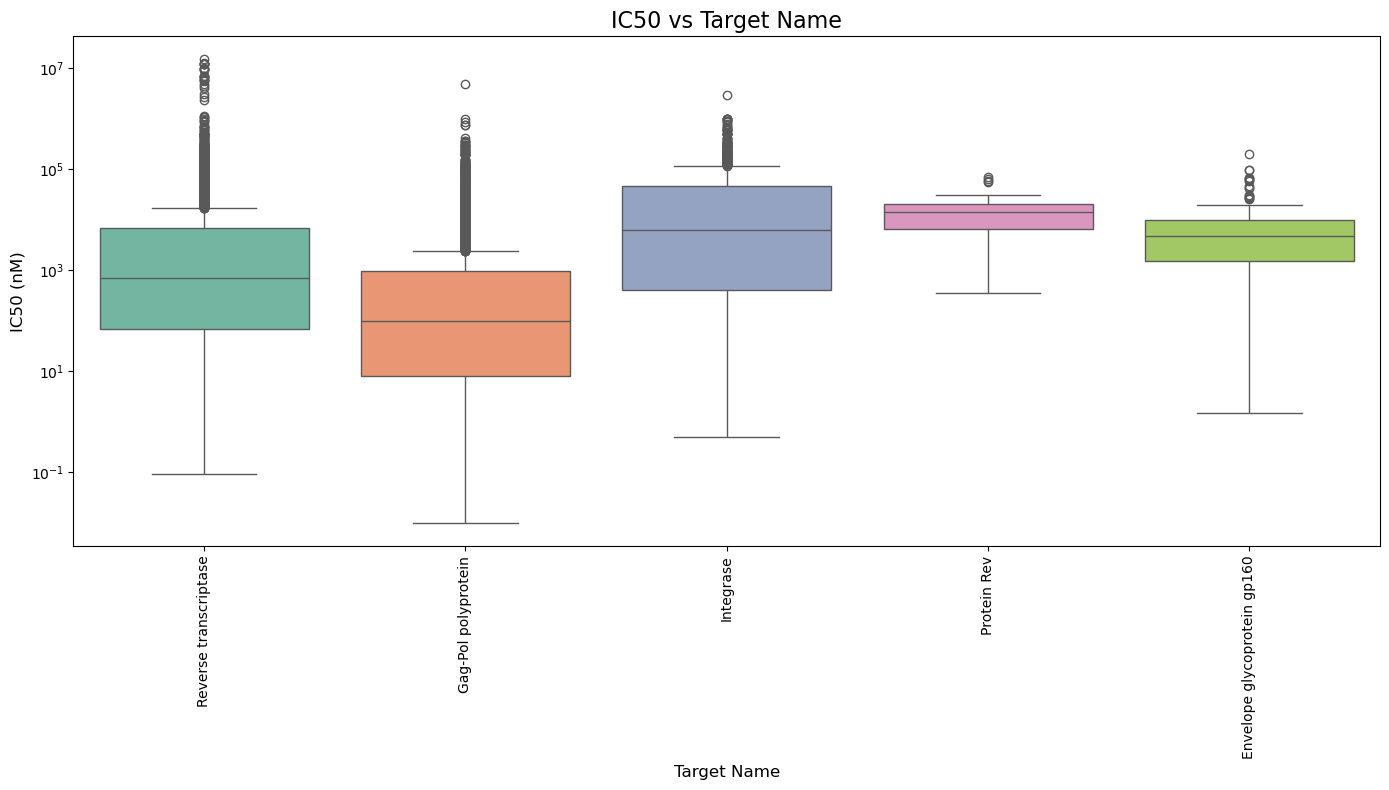

In [80]:
evaluation_utils.create_ic50_boxplot(train_df)

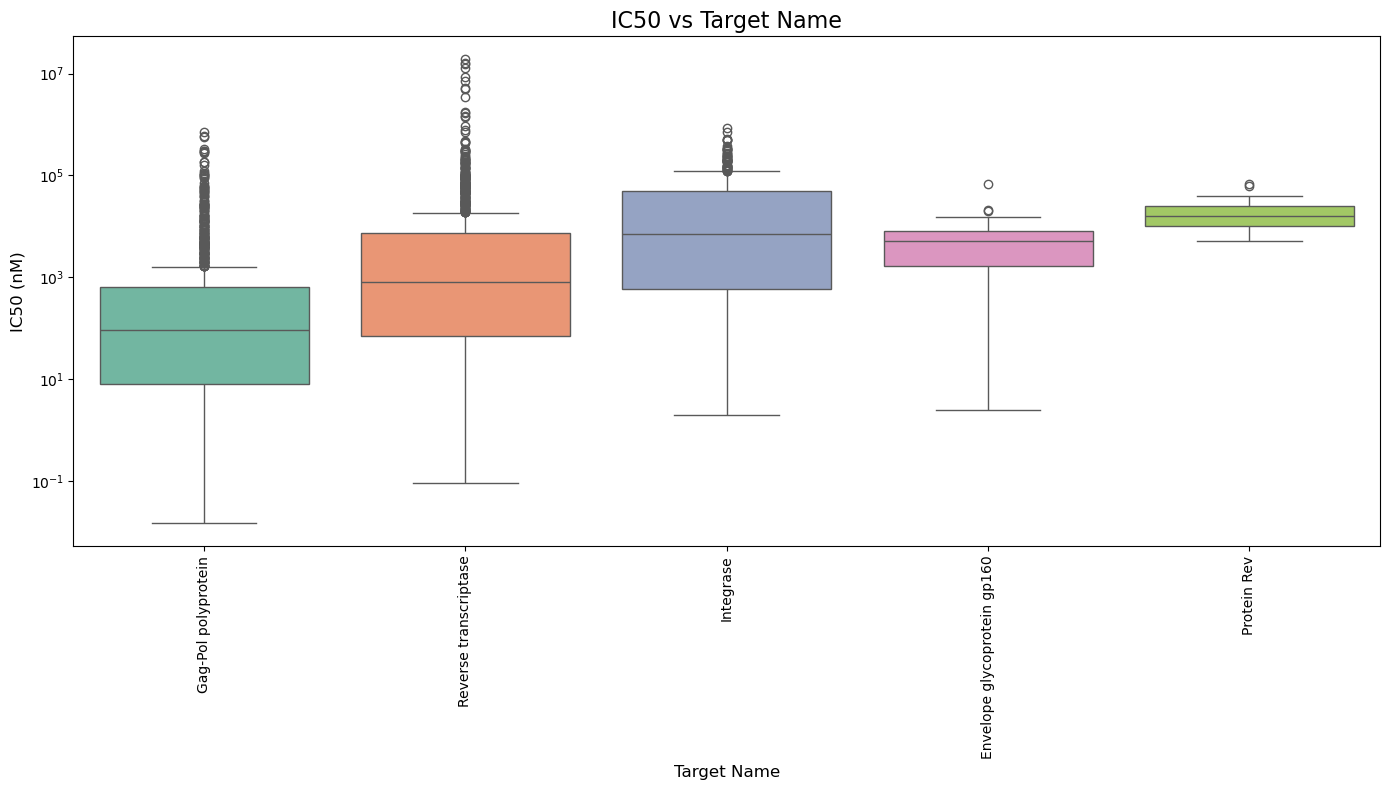

In [82]:
evaluation_utils.create_ic50_boxplot(test_df)

To statistically compare the IC50 values for the targeted proteins (`Gag-Pol polyprotein`, `Reverse transcriptase`, `Protein Rev`, and `Envelope glycoprotein gp160`), we initially considered using **ANOVA (Analysis of Variance)**.

ANOVA is used to test whether there are significant differences in the means of three or more groups. It operates under the following hypotheses:
- H0 (Null Hypothesis): The means of all groups are equal.
- H1 (Alternative Hypothesis): At least one group mean is different.

ANOVA assumes that the data in each group are normally distributed. To validate this assumption, we performed the *Kolmogorov-Smirnov* test for normality, as the dataset was too large to use the *Shapiro-Wilk* test. The *Kolmogorov-Smirnov* test evaluates whether the data conforms to a specified distribution, the normal in our case. The hypotheses for the test are:

- H0: The data follows a normal distribution.
- H1: The data does not follow a normal distribution.

In [85]:
evaluation_utils.perform_ks_test(train_df, group_col='Target Name', value_col='Log_IC50')

Reverse transcriptase: KS-Test Statistic = 0.03665815505168257, p-value = 4.922017557325594e-06
Gag-Pol polyprotein: KS-Test Statistic = 0.02374269618304642, p-value = 0.017436020580938592
Integrase: KS-Test Statistic = 0.09284043062843073, p-value = 4.9980937770128974e-14
Protein Rev: KS-Test Statistic = 0.15350567850592867, p-value = 0.17884543612883175
Envelope glycoprotein gp160: KS-Test Statistic = 0.10869262113078909, p-value = 0.045335264436659806


In [87]:
evaluation_utils.perform_ks_test(test_df, group_col='Target Name', value_col='Log_IC50')

Gag-Pol polyprotein: KS-Test Statistic = 0.02328581777647798, p-value = 0.6358555116723809
Reverse transcriptase: KS-Test Statistic = 0.03955403690698672, p-value = 0.04374414317021369
Integrase: KS-Test Statistic = 0.09203583480045296, p-value = 0.0006588471778138449
Envelope glycoprotein gp160: KS-Test Statistic = 0.16744562382275552, p-value = 0.15985943070726505
Protein Rev: KS-Test Statistic = 0.11895589228201431, p-value = 0.9464139271103875


As shown in the results of the *Kolmogorov-Smirnov* test, not all distributions are normally distributed within the train and test set. Therefore, we will the *Kruskal-Wallis* test as a non-parametric alternative to ANOVA, and start considering the medians of the logarithmic $IC50$ instead of the means, since this metric is more robust to skewed distributions.

The *Kruskal-Wallis* Test is a rank-based test that does not assume normality. It evaluates whether the medians of two or more groups are significantly different. The hypotheses for the *Kruskal-Wallis* test are:

- H0 (Null Hypothesis): The distributions (and medians) of all groups are equal.
- H1 (Alternative Hypothesis): At least one group has a different median.

In [90]:
evaluation_utils.perform_kruskal_wallis_test(train_df, group_col='Target Name', value_col='Log_IC50')

Kruskal-Wallis Test: H-statistic = 1584.9943042170407, p-value = 0.0
Significant differences found between groups.


In [92]:
evaluation_utils.perform_kruskal_wallis_test(test_df, group_col='Target Name', value_col='Log_IC50')

Kruskal-Wallis Test: H-statistic = 470.7614225697541, p-value = 1.409509403664152e-100
Significant differences found between groups.


We found that significant differences between the medians of the groups of both sets are present. We will now perform a post-hoc **Dunn's test**.

Dunn's test is a non-parametric post-hoc test used after a significant *Kruskal-Wallis* test to identify which specific groups differ in their medians. It performs pairwise comparisons between all groups and adjusts p-values to account for multiple testing.

- $H_0$: The medians of the two groups being compared are equal.
- $H_1$: The medians of the two groups being compared are different.

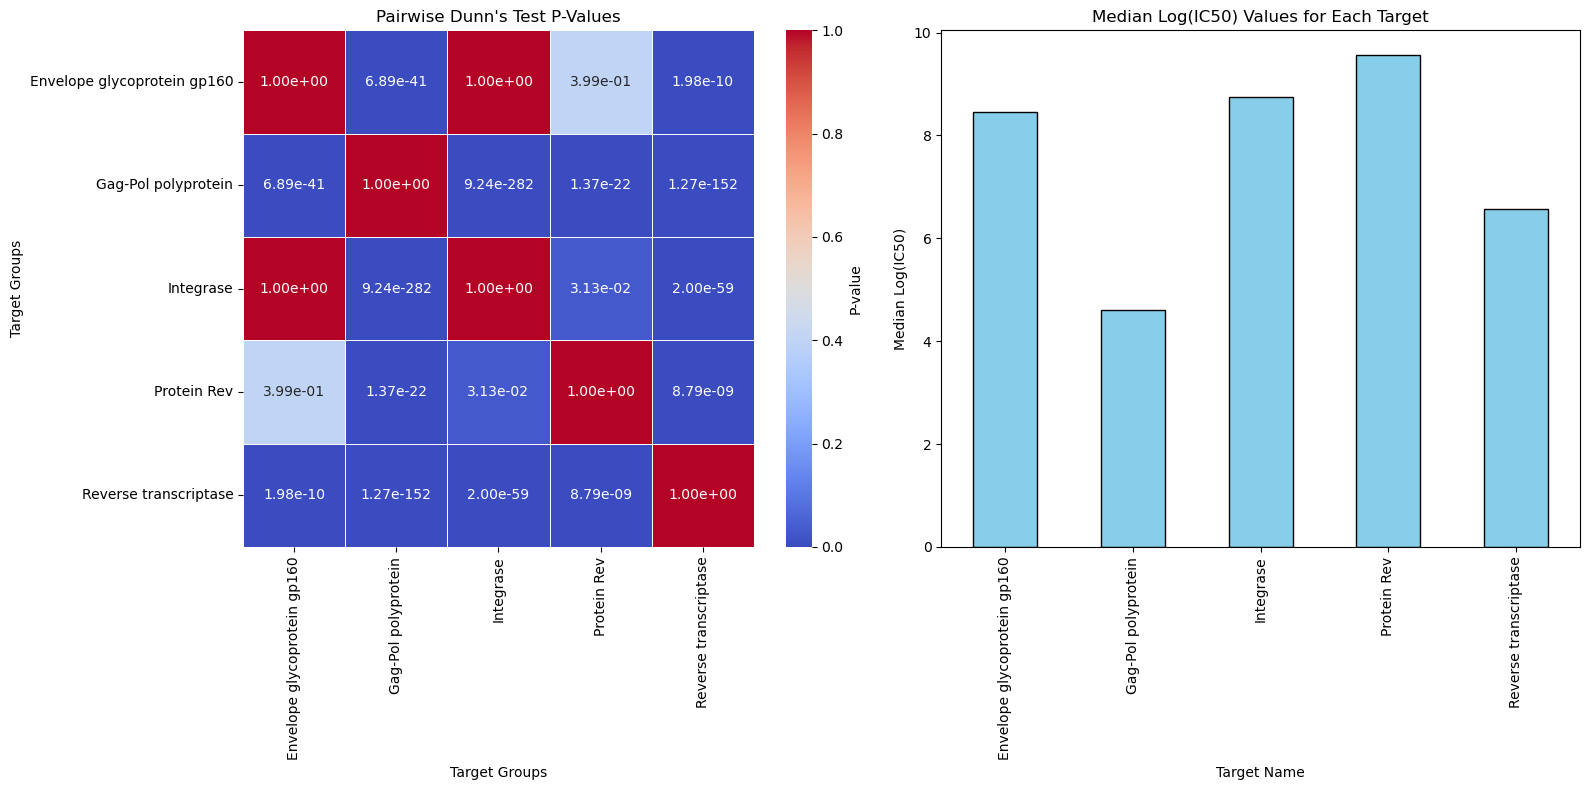

In [95]:
evaluation_utils.perform_posthoc_dunn_and_plot(
    train_df, 
    group_col='Target Name', 
    value_col='Log_IC50', 
    p_adjust_method='bonferroni'
)


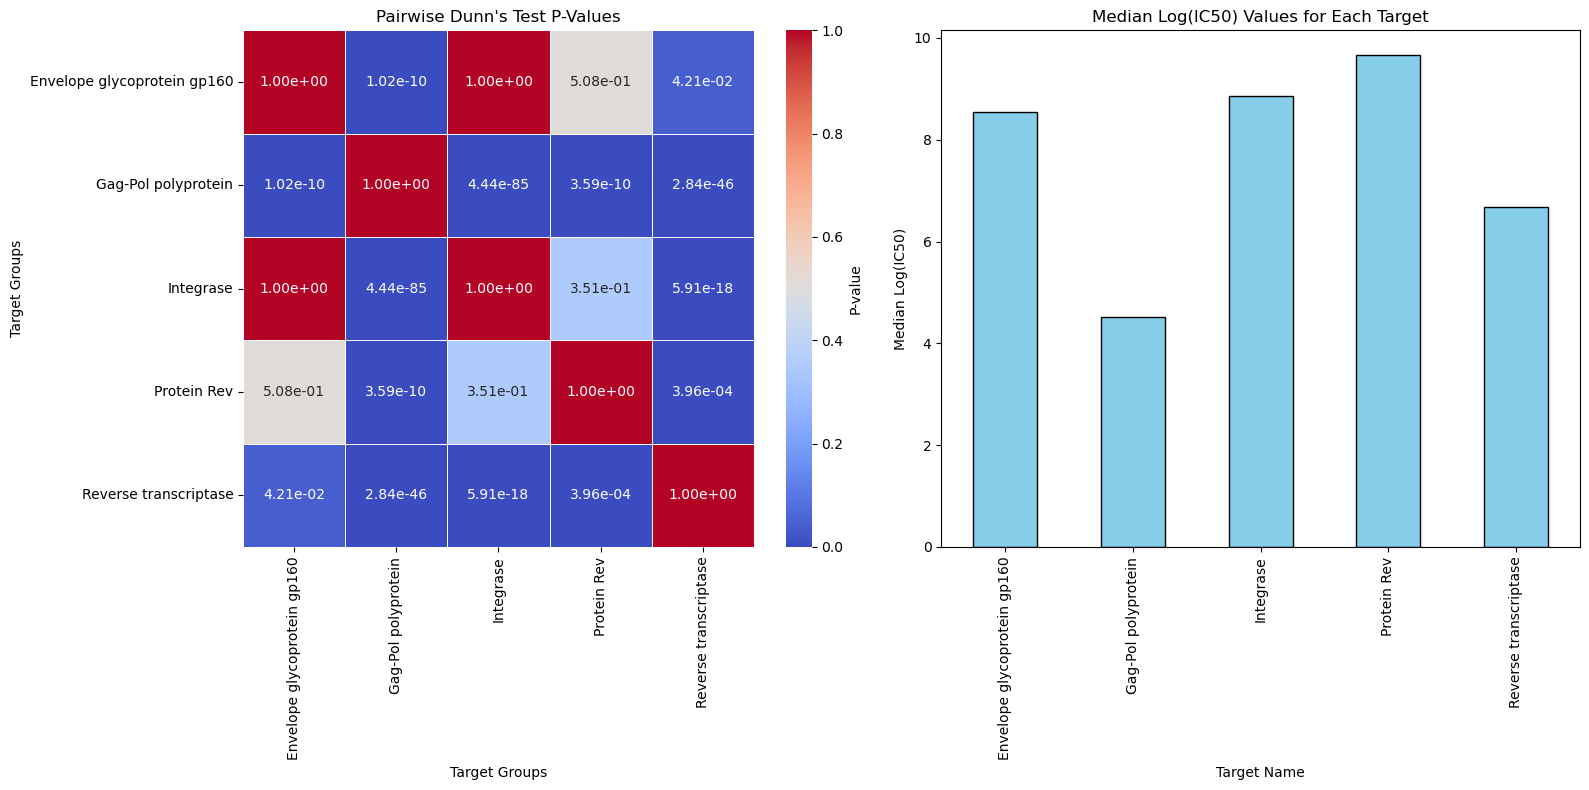

In [96]:
evaluation_utils.perform_posthoc_dunn_and_plot(
    test_df, 
    group_col='Target Name', 
    value_col='Log_IC50', 
    p_adjust_method='bonferroni'
)


From the results of the pairwise Dunn's test (left plot), we observe that between the Gag-Pol polyprotein and other targets the p-values are extremely small compared to other target proteins in both set. This implies that, at the standard significance level of 0.05, Gag-Pol polyprotein median logarithmic $IC50$ is **significantly different** from the other groups in both train and test set. By looking at the median $IC50$ values for the groups (right plot), we observe that Gag-Pol polyprotein's one is **lower** than those for other groups.  


## features analysis (splitted dataset)

In this part we perform the test for the kruscal-wallis and dunn tests on the splitted dataset. In order to do so, let's catch up with the code from results.ipynb:

In [100]:
hivRD = test_df[test_df['Target Name'] == 'Gag-Pol polyprotein']
hivRD = train_df[train_df['Target Name'] == 'Gag-Pol polyprotein']

hivRD_test = data_utils.nan_to_numeric(test_df)
hivRD_train = data_utils.nan_to_numeric(train_df)

In [102]:
hivRD_test['Mol'] = hivRD_test['Ligand SMILES'].apply(rdkit_extraction.smiles_to_mol)
hivRD_train['Mol'] = hivRD_train['Ligand SMILES'].apply(rdkit_extraction.smiles_to_mol)

In [103]:
# Calculate descriptors and add them to the DataFrame
descriptor_df = hivRD_test['Mol'].apply(lambda mol: rdkit_extraction.calculate_descriptors(mol))
hivRD_test= pd.concat([hivRD_test, descriptor_df], axis=1)

In [104]:
descriptor_df = hivRD_train['Mol'].apply(lambda mol: rdkit_extraction.calculate_descriptors(mol))
hivRD_train= pd.concat([hivRD_train, descriptor_df], axis=1)

In [106]:
num_df_test, non_numerical_df_test = data_utils.separe_num_df(hivRD_test)
num_df_test= (num_df_test - num_df_test.min())/(num_df_test.max() - num_df_test.min())
num_df_test = num_df_test.drop(columns=['NumRadicalElectrons']) #column dropped as it was all 0-valued

In [107]:
num_df_train, non_numerical_df_train = data_utils.separe_num_df(hivRD_train)
num_df_train = (num_df_train - num_df_train.min()) / (num_df_train.max() - num_df_train.min())
num_df_train = num_df_train.drop(columns=['NumRadicalElectrons'])  # Column dropped as it was all 0-valued


In [109]:
pca_train= num_df_train.drop(columns=['Log_IC50','index', 'BindingDB Reactant_set_id', 'BindingDB MonomerID', 'IC50 (nM)', 'Number of Protein Chains in Target (>1 implies a multichain complex)'])
pca_test= num_df_test.drop(columns=['Log_IC50','index', 'BindingDB Reactant_set_id', 'BindingDB MonomerID', 'IC50 (nM)', 'Number of Protein Chains in Target (>1 implies a multichain complex)'])

In [110]:
#run pca
reduced_data_test, loadings_df_test, explained_variance_test = evaluation_utils.run_pca(pca_test, n_components=0.9)
reduced_data_train, loadings_df_train, explained_variance_train = evaluation_utils.run_pca(pca_train, n_components=0.9)

In [111]:
feature_contributions_train = evaluation_utils.compute_pca_feature_contributions(explained_variance_train, loadings_df_train, top_n_components=loadings_df_train.shape[0])
feature_contributions_test = evaluation_utils.compute_pca_feature_contributions(explained_variance_test, loadings_df_test, top_n_components=loadings_df_test.shape[0])


In [112]:
feature_contributions_test

FormalCharge                       0.013164
NumBridgeheadAtoms                 0.016996
NumSaturatedCarbocycles            0.046201
LogP                               0.060626
TPSA                               0.082106
NumHDonors                         0.082756
BertzCT                            0.083265
NumRotatableBonds                  0.086920
MolWt                              0.094983
MolMR                              0.095189
Chi0n                              0.097244
NumHAcceptors                      0.097698
Chi0v                              0.097716
Chi1n                              0.098989
Chi1v                              0.103796
NumAtomStereoCenters               0.116956
NumSaturatedRings                  0.117768
NumAliphaticRings                  0.123241
BalabanJ                           0.124936
NumSaturatedHeterocycles           0.131294
RingCount                          0.140594
NumUnspecifiedAtomStereoCenters    0.182090
NumAromaticRings                

In [113]:
feature_contributions_train

FormalCharge                       0.008896
NumSpiroAtoms                      0.044483
NumUnspecifiedAtomStereoCenters    0.044661
LogP                               0.051280
BertzCT                            0.063836
RingCount                          0.071471
NumAromaticRings                   0.073519
NumBridgeheadAtoms                 0.078081
NumSaturatedHeterocycles           0.084399
MolMR                              0.090462
TPSA                               0.092282
Chi1n                              0.093348
MolWt                              0.093634
Chi1v                              0.094717
Chi0v                              0.096751
Chi0n                              0.097042
NumHDonors                         0.097071
NumSaturatedRings                  0.108359
NumHAcceptors                      0.109312
NumRotatableBonds                  0.109891
NumAtomStereoCenters               0.144713
NumAliphaticRings                  0.145813
BalabanJ                        

In both train and set still sp3 explains the highest variance.

In [140]:
frc_test = pca_test['FractionCSP3'].values
frc_train = pca_train['FractionCSP3'].values

def get_quantiles(frc, numerical_df_pca):
    q1, q3 = np.quantile(frc, [0.25, 0.75])
    numerical_df_pca['frc_class'] = 1  # Initialize all values to 2
    numerical_df_pca.loc[numerical_df_pca['FractionCSP3'] < q1, 'frc_class'] = 0  # Assign 0 where CSP3 < q1
    numerical_df_pca.loc[numerical_df_pca['FractionCSP3'] > q3, 'frc_class'] = 2  # Assign 1 where CSP3 > q3

get the ic50 distribution for the quartiles classes of sp3:

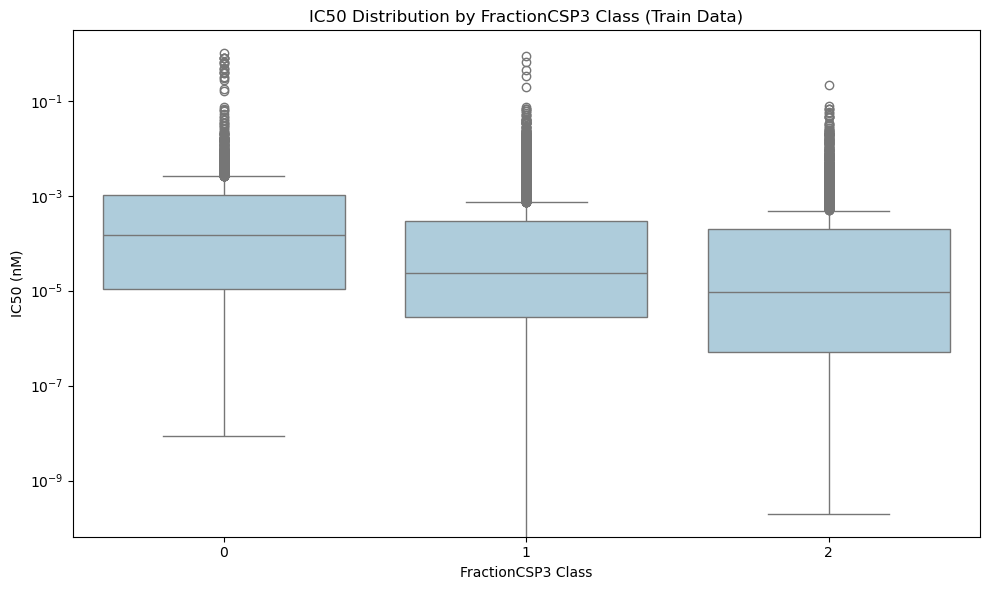

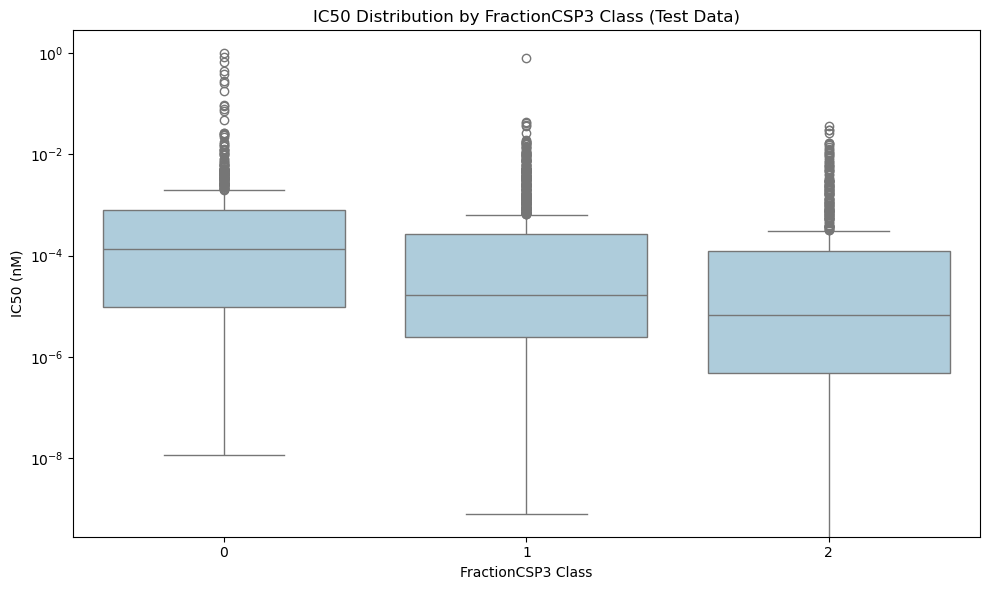

In [142]:
# Add the frc_class column to num_df_train and num_df_test
get_quantiles(frc_train, num_df_train)  # Pass num_df_train instead of pca_train
get_quantiles(frc_test, num_df_test)    # Pass num_df_test instead of pca_test

# Ensure 'IC50' column exists in num_df_train and num_df_test
num_df_train['IC50'] = num_df_train['IC50 (nM)'].values
num_df_test['IC50'] = num_df_test['IC50 (nM)'].values

# Plot boxplot for train dataset
plt.figure(figsize=(10, 6))
sns.boxplot(x='frc_class', y='IC50', data=num_df_train)
plt.yscale('log')
plt.xlabel('FractionCSP3 Class')
plt.ylabel('IC50 (nM)')
plt.title('IC50 Distribution by FractionCSP3 Class (Train Data)')
plt.tight_layout()
plt.show()

# Plot boxplot for test dataset
plt.figure(figsize=(10, 6))
sns.boxplot(x='frc_class', y='IC50', data=num_df_test)
plt.yscale('log')
plt.xlabel('FractionCSP3 Class')
plt.ylabel('IC50 (nM)')
plt.title('IC50 Distribution by FractionCSP3 Class (Test Data)')
plt.tight_layout()
plt.show()

Visually the lowest median is in the third class as expected from results notebook. but let's put it to the test:

In [147]:
evaluation_utils.perform_ks_test(num_df_train, group_col='frc_class', value_col='IC50')
evaluation_utils.perform_ks_test(num_df_test, group_col='frc_class', value_col='IC50')

1: KS-Test Statistic = 0.4658517112063122, p-value = 0.0
2: KS-Test Statistic = 0.4292005061084583, p-value = 0.0
0: KS-Test Statistic = 0.45593007756728043, p-value = 0.0
2: KS-Test Statistic = 0.4032152621109252, p-value = 1.2068790056835978e-100
0: KS-Test Statistic = 0.45110049412535314, p-value = 9.151224303538661e-128
1: KS-Test Statistic = 0.4737888944119965, p-value = 9.377121420793893e-286


all p value are low therefore there's no normality in the dataset. For this reason to compare such groups we can use again the Kruskal Wallis test.

In [153]:
evaluation_utils.perform_kruskal_wallis_test(num_df_train, group_col='frc_class', value_col='IC50')
evaluation_utils.perform_kruskal_wallis_test(num_df_test, group_col='frc_class', value_col='IC50')

Kruskal-Wallis Test: H-statistic = 572.620469647702, p-value = 4.539885540558483e-125
Significant differences found between groups.
Kruskal-Wallis Test: H-statistic = 166.23514511644717, p-value = 7.989082183714662e-37
Significant differences found between groups.


There's a significant difference between the distribution. Let's compare medians

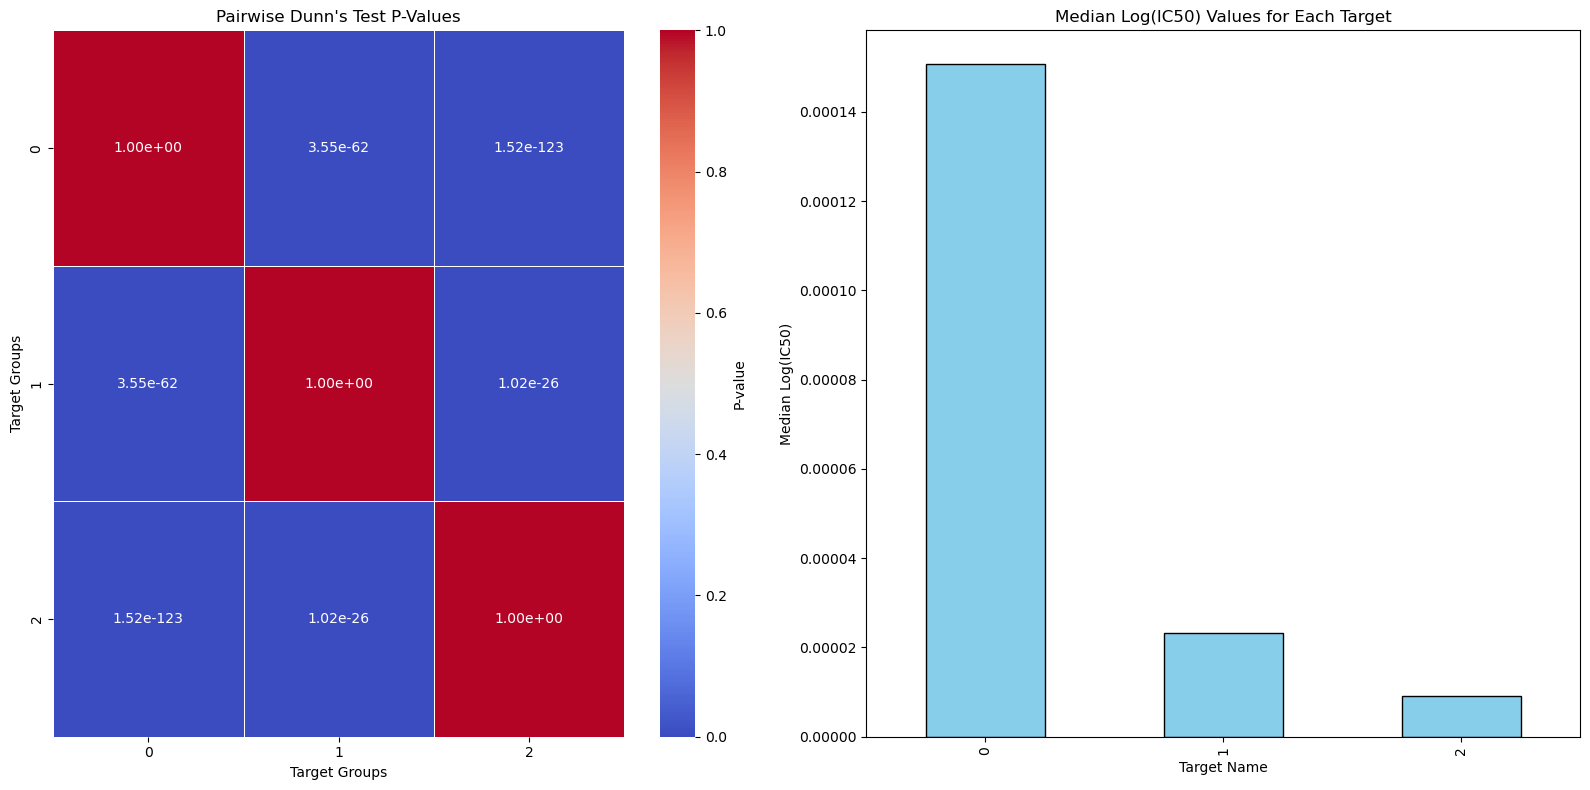

In [157]:
evaluation_utils.perform_posthoc_dunn_and_plot(
    num_df_train, 
    group_col='frc_class', 
    value_col='IC50', 
    p_adjust_method='bonferroni'
)

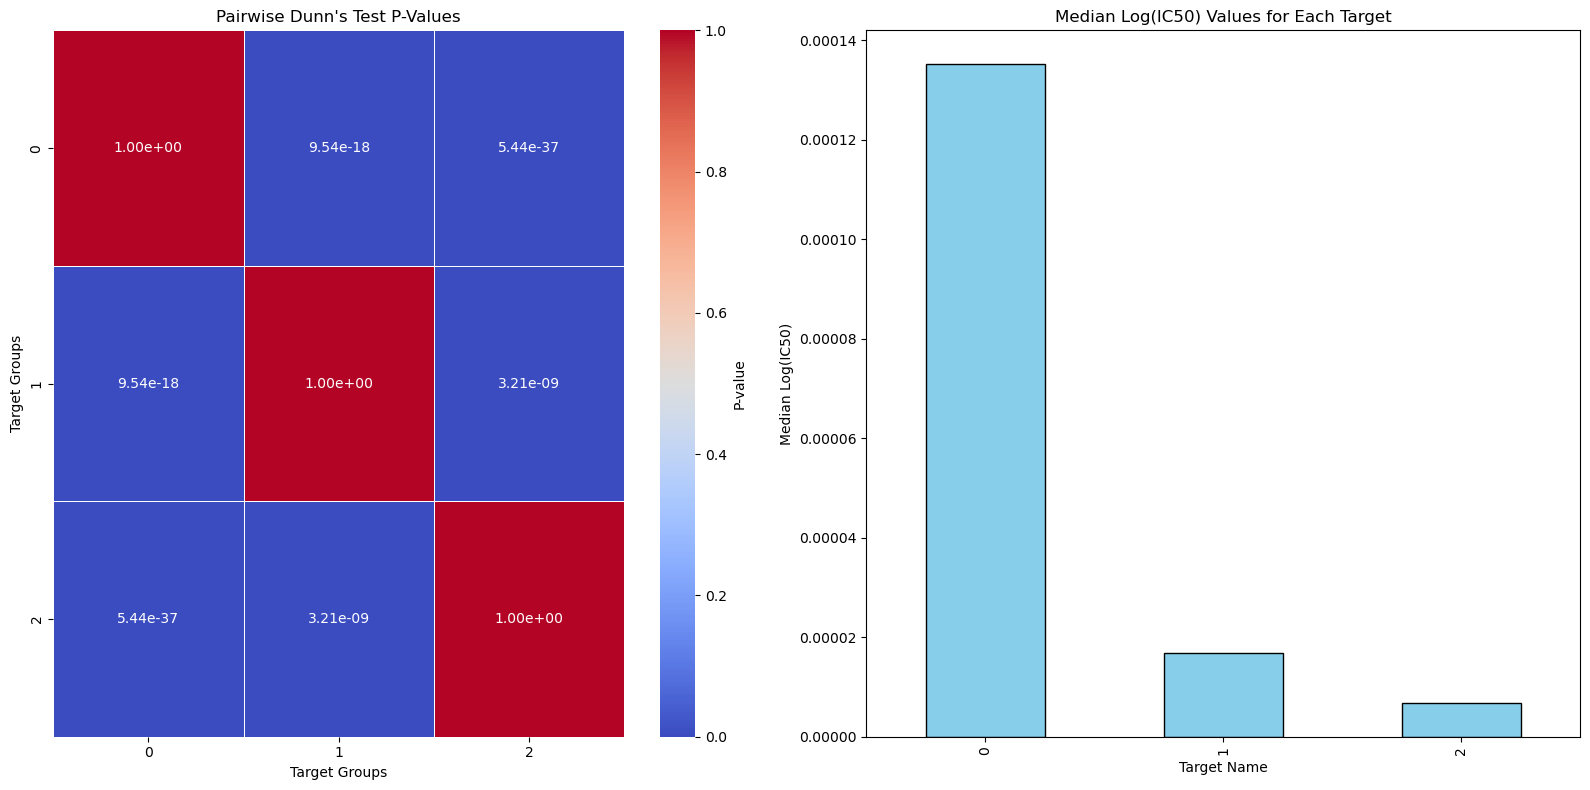

In [159]:
evaluation_utils.perform_posthoc_dunn_and_plot(
    num_df_test, 
    group_col='frc_class', 
    value_col='IC50', 
    p_adjust_method='bonferroni'
)

From the test result, we can see that the group with the highest number of sp3 hybridized carbons seems to have a singificantly lower median IC50 than the other groups in both training and test set. This validates our results with the full dataset.